# Histimator: A Tutorial

This notebook walks through the full functionality of **Histimator**, a
histogram-template statistical inference package for particle physics.
We proceed from basic building blocks up to full hypothesis tests, with
mathematics and visualisations at each stage.

Template fitting is the dominant statistical methodology in high-energy
physics measurements and searches.  The central idea is simple: we
predict observed event counts in bins of some discriminating variable
as a sum of process "templates" (histograms), each scaled by physical
or nuisance parameters.  We then compare the prediction to data using
a likelihood function and extract parameter estimates, confidence
intervals, and significances.

The mathematical framework underpinning this is called **HistFactory**
(Cranmer et al., 2012, CERN-OPEN-2012-016).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.stats as stats

# Use a clean style
plt.rcParams.update({
    'figure.figsize': (8, 5),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 13,
})

# Histimator imports
from histimator.parameters import Parameter
from histimator.histograms import Histogram
from histimator.interpolation import InterpolationCode, interpolate
from histimator.samples import Sample
from histimator.channels import Channel
from histimator.model import Model
from histimator.likelihood import BinnedNLL, _poisson_logpdf, fit
from histimator.inference import profile_likelihood_ratio, upper_limit, discovery_significance


## 1. Parameters

Every degree of freedom in our statistical model is represented by a
`Parameter`. This is the atomic unit of the framework: a named scalar
with an optional allowed range and a flag controlling whether the
minimiser should float it.

In the HistFactory formalism, parameters fall into two categories.
**Parameters of interest** (POI) are the quantities we want to measure,
like a signal cross-section normalised to its Standard Model prediction
(conventionally called $\mu$).  **Nuisance parameters** encode
systematic uncertainties: each one is centred at a nominal value and
constrained by auxiliary measurements or prior knowledge.

In [2]:
# A parameter of interest: signal strength
mu = Parameter("mu", value=1.0, bounds=(0.0, 5.0))
print(f"Name:   {mu.name}")
print(f"Value:  {mu.value}")
print(f"Bounds: {mu.bounds}")
print(f"Fixed:  {mu.fixed}")


Name:   mu
Value:  1.0
Bounds: (0.0, 5.0)
Fixed:  False


In [3]:
# A nuisance parameter: centred at 0, constrained to +/- a few sigma
alpha = Parameter("bkg_norm", value=0.0, bounds=(-5.0, 5.0))
print(f"Name:   {alpha.name}")
print(f"Value:  {alpha.value}")

# Clone with a different starting value (original is unchanged)
alpha2 = alpha.clone(value=0.5)
print(f"Cloned value: {alpha2.value}, original: {alpha.value}")


Name:   bkg_norm
Value:  0.0
Cloned value: 0.5, original: 0.0


In [4]:
# Parameters produce dicts ready for iminuit
print("POI init:", mu.to_minuit_init())
print("NP init: ", alpha.to_minuit_init())

# A fixed parameter
fixed_p = Parameter("lumi", value=1.0, fixed=True)
print("Fixed:   ", fixed_p.to_minuit_init())


POI init: {'mu': 1.0, 'limit_mu': (0.0, 5.0)}
NP init:  {'bkg_norm': 0.0, 'limit_bkg_norm': (-5.0, 5.0)}
Fixed:    {'lumi': 1.0, 'fix_lumi': True}


Bounds are validated at construction. Setting a value outside
bounds, or inverting the range, raises immediately rather than
propagating a silent error into the fit.

In [5]:
# These raise ValueError
try:
    Parameter("bad", value=10.0, bounds=(0.0, 3.0))
except ValueError as e:
    print(f"Out of bounds: {e}")

try:
    Parameter("bad", value=1.0, bounds=(5.0, 2.0))
except ValueError as e:
    print(f"Inverted bounds: {e}")


Out of bounds: Parameter 'bad': value 10.0 is outside bounds (0.0, 3.0)
Inverted bounds: Parameter 'bad': lower bound 5.0 must be strictly less than upper bound 2.0


## 2. Histograms

The `Histogram` is the core data container. It wraps bin contents and
bin edges into an immutable object with vectorised arithmetic,
integration, and accessor properties.

In template fitting we work exclusively with binned data: each bin
records a count (or weighted sum) of events in a range of some observable.
The mathematical object is a step function over the observable axis.
The predicted count in bin $i$ is denoted $\nu_i$ and the observed count $n_i$.

In [6]:
# Build a simple histogram
h = Histogram([10, 20, 40, 20, 10], [0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
print(h)
print(f"Bin centres: {h.centres}")
print(f"Bin widths:  {h.widths}")
print(f"Total:       {h.total}")


Histogram(nbins=5, range=(0, 5), total=100)
Bin centres: [0.5 1.5 2.5 3.5 4.5]
Bin widths:  [1. 1. 1. 1. 1.]
Total:       100.0


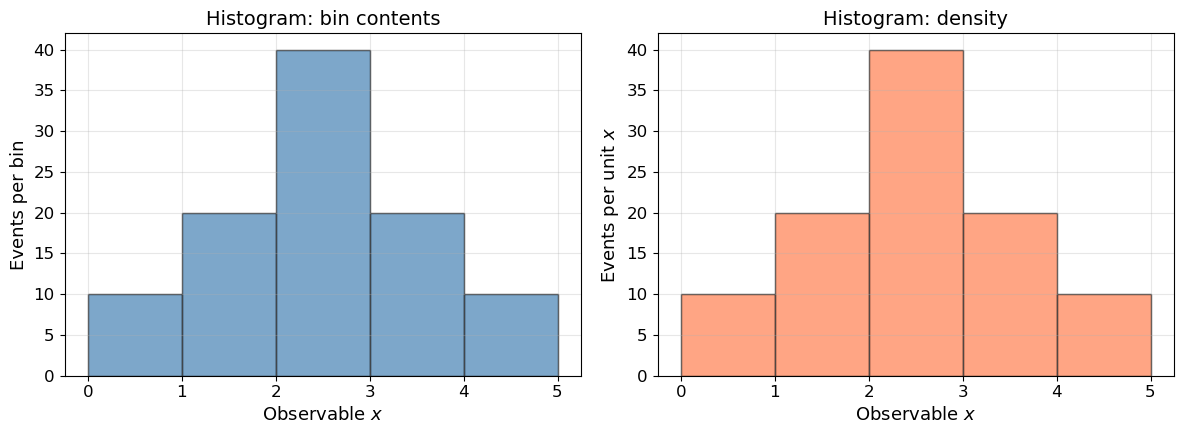

In [7]:
# Visualise
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Left: bar chart of bin contents
axes[0].bar(h.centres, h.values, width=h.widths, edgecolor='black',
            alpha=0.7, color='steelblue')
axes[0].set_xlabel("Observable $x$")
axes[0].set_ylabel("Events per bin")
axes[0].set_title("Histogram: bin contents")

# Right: density (events per unit x)
axes[1].bar(h.centres, h.density, width=h.widths, edgecolor='black',
            alpha=0.7, color='coral')
axes[1].set_xlabel("Observable $x$")
axes[1].set_ylabel("Events per unit $x$")
axes[1].set_title("Histogram: density")

plt.tight_layout()
plt.show()


**Immutability** is enforced: once constructed, bin contents and edges
cannot be modified in place.  Arithmetic operations always return new
objects.  This prevents accidental mutation bugs in complex model
building.

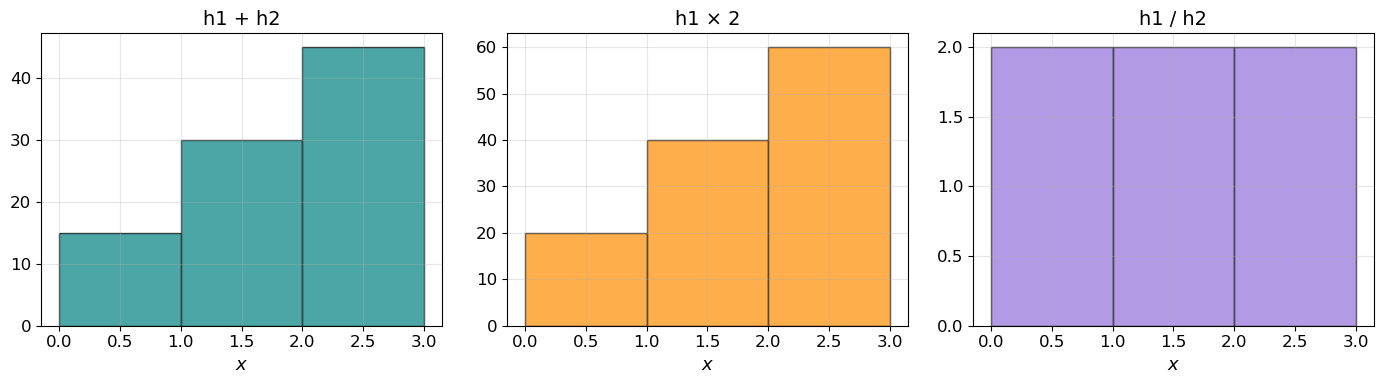

Safe division (0/0 -> 0): [0. 2. 0.]


In [8]:
# Arithmetic creates new histograms
h1 = Histogram([10, 20, 30], [0.0, 1.0, 2.0, 3.0])
h2 = Histogram([5, 10, 15], [0.0, 1.0, 2.0, 3.0])

h_sum = h1 + h2
h_scaled = h1 * 2.0
h_ratio = h1 / h2

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, hh, title, color in [
    (axes[0], h_sum, "h1 + h2", "teal"),
    (axes[1], h_scaled, "h1 × 2", "darkorange"),
    (axes[2], h_ratio, "h1 / h2", "mediumpurple"),
]:
    ax.bar(hh.centres, hh.values, width=hh.widths, edgecolor='black',
           alpha=0.7, color=color)
    ax.set_title(title)
    ax.set_xlabel("$x$")

plt.tight_layout()
plt.show()

# Division by zero is safe: 0/0 -> 0
h_zero = Histogram([0, 10, 0], [0.0, 1.0, 2.0, 3.0])
ratio_safe = h1 / h_zero
print(f"Safe division (0/0 -> 0): {ratio_safe.values}")


**Integration** sums bin contents over a range, handling partial bins
proportionally.  If we integrate from $a$ to $b$ where $a$ falls midway
through bin $i$, only the fractional overlap of that bin is included.

In [9]:
h = Histogram([10, 20, 30, 40], [0.0, 1.0, 2.0, 3.0, 4.0])
print(f"Full range:   {h.integrate()}")
print(f"[0, 2]:       {h.integrate(0, 2)}")
print(f"[0.5, 2.5]:   {h.integrate(0.5, 2.5)}")  # half of bin0 + all of bin1 + half of bin2
print(f"[10, 20]:     {h.integrate(10, 20)}")     # out of range -> 0


Full range:   100.0
[0, 2]:       30.0
[0.5, 2.5]:   40.0
[10, 20]:     0.0


## 3. Interpolation Schemes

Systematic uncertainties enter the model through **interpolation**: given
a nominal prediction and its up/down variations (evaluated at
$\alpha = +1$ and $\alpha = -1$ of a nuisance parameter), we need a
smooth function that passes through all three points and extends to
arbitrary $\alpha$.

All schemes satisfy three boundary conditions:

$$f(\alpha=0) = \text{nominal}, \quad f(\alpha=+1) = \text{up}, \quad f(\alpha=-1) = \text{down}$$

The four HistFactory interpolation codes offer different tradeoffs between
smoothness, positivity, and computational cost.

**Code 0: Piecewise linear.** The simplest option.  Linear in $\alpha$ on
each side of zero, but the first derivative is discontinuous at
$\alpha = 0$ when up and down variations are asymmetric.  This kink can
cause the minimiser to converge slowly.

$$f(\alpha) = \begin{cases} \text{nom} + \alpha\,(\text{up} - \text{nom}) & \alpha \geq 0 \\ \text{nom} - \alpha\,(\text{down} - \text{nom}) & \alpha < 0 \end{cases}$$

**Code 1: Piecewise exponential.** The default in most HistFactory
analyses.  Takes the form $\text{nom} \times (\text{up}/\text{nom})^\alpha$,
which guarantees positive yields and produces smooth (exponential)
variation everywhere.

**Code 2: Quadratic/linear.** A parabola in $|\alpha| \leq 1$ that removes
the kink at zero, switching to linear extrapolation beyond $\pm 1$.
This is a good compromise between smoothness near the nominal and
controlled behaviour in the tails.

**Code 3: Degree-6 polynomial/exponential.** The most sophisticated
scheme.  A sixth-degree polynomial for $|\alpha| \leq 1$ is constructed
to match the exponential form and its first two derivatives at the
boundaries $\alpha = \pm 1$.  This gives $C^2$ continuity everywhere.

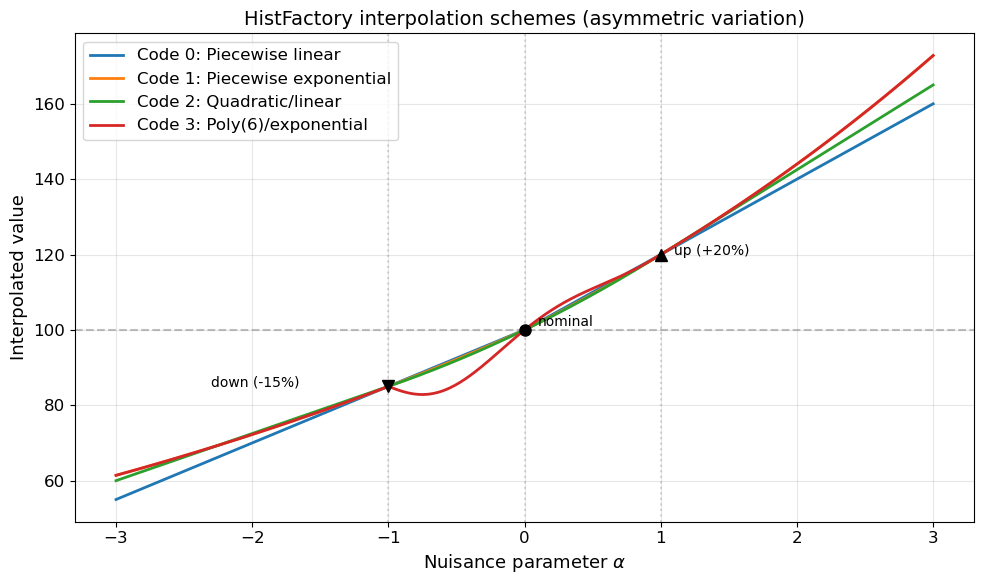

In [10]:
# Compare all four schemes across a range of alpha
alpha_range = np.linspace(-3, 3, 500)
nom_val = 100.0
down_val = 85.0   # -15% at alpha=-1
up_val = 120.0    # +20% at alpha=+1

schemes = [
    (InterpolationCode.PIECEWISE_LINEAR,      "Code 0: Piecewise linear",      "#1f77b4"),
    (InterpolationCode.PIECEWISE_EXPONENTIAL, "Code 1: Piecewise exponential", "#ff7f0e"),
    (InterpolationCode.QUADRATIC_LINEAR,      "Code 2: Quadratic/linear",      "#2ca02c"),
    (InterpolationCode.POLY_EXPONENTIAL,      "Code 3: Poly(6)/exponential",   "#d62728"),
]

fig, ax = plt.subplots(figsize=(10, 6))

for interp_code, label, color in schemes:
    values = [float(interpolate(a, nom_val, down_val, up_val, interp_code))
              for a in alpha_range]
    ax.plot(alpha_range, values, label=label, color=color, linewidth=2)

# Mark the boundary conditions
ax.axhline(nom_val, color='gray', ls='--', alpha=0.5)
ax.plot(0, nom_val, 'ko', ms=8, zorder=5)
ax.plot(1, up_val, 'k^', ms=8, zorder=5)
ax.plot(-1, down_val, 'kv', ms=8, zorder=5)

ax.axvline(-1, color='gray', ls=':', alpha=0.3)
ax.axvline(0, color='gray', ls=':', alpha=0.3)
ax.axvline(1, color='gray', ls=':', alpha=0.3)

ax.annotate('nominal', (0.1, nom_val + 1), fontsize=10)
ax.annotate('up (+20%)', (1.1, up_val), fontsize=10)
ax.annotate('down (-15%)', (-2.3, down_val), fontsize=10)

ax.set_xlabel(r"Nuisance parameter $\alpha$")
ax.set_ylabel("Interpolated value")
ax.set_title("HistFactory interpolation schemes (asymmetric variation)")
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


The key differences become clear in the plot above. Code 0 has a visible
kink at $\alpha = 0$ because the up and down variations are asymmetric
(+20% vs -15%).  Code 1 (exponential) is smooth everywhere but grows
rapidly for large $|\alpha|$.  Code 2 removes the kink via a parabola
near zero but transitions to linear growth beyond $|\alpha| = 1$.
Code 3 provides the smoothest interpolation in $[-1, 1]$ and matches
the exponential form outside.

A critical property of the exponential-based schemes (Codes 1 and 3) is
that they guarantee **positive yields**.  The linear and quadratic schemes
can produce negative predictions for large negative $\alpha$, which is
unphysical for event counts.

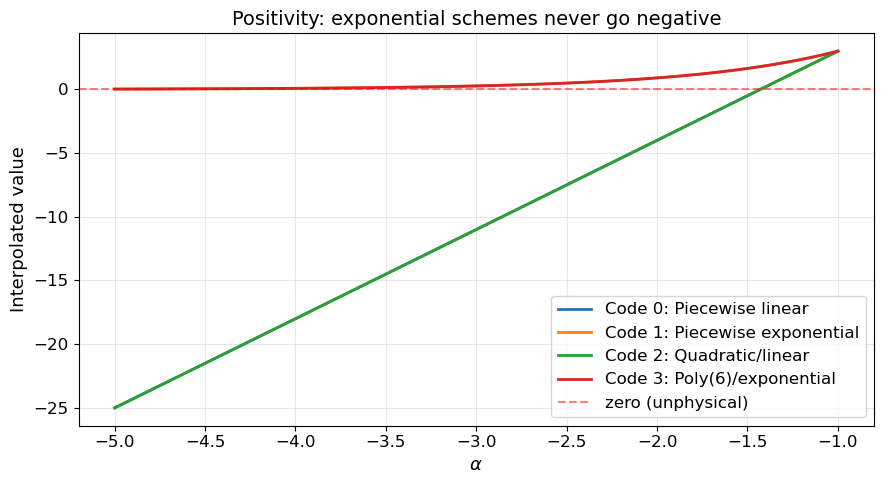

In [11]:
# Demonstrate positivity: push alpha very negative
alpha_neg = np.linspace(-5, -1, 200)
nom_small = 10.0
down_small = 3.0
up_small = 17.0

fig, ax = plt.subplots(figsize=(9, 5))
for interp_code, label, color in schemes:
    values = [float(interpolate(a, nom_small, down_small, up_small, interp_code))
              for a in alpha_neg]
    ax.plot(alpha_neg, values, label=label, color=color, linewidth=2)

ax.axhline(0, color='red', ls='--', alpha=0.5, label='zero (unphysical)')
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Interpolated value")
ax.set_title("Positivity: exponential schemes never go negative")
ax.legend()
plt.tight_layout()
plt.show()


## 4. Building a Statistical Model

A HistFactory model has three layers of structure.

A **Sample** represents a single physics process (signal, $t\bar{t}$
background, $W$+jets, etc.) in a single analysis region.  It carries
a nominal histogram template and an ordered list of *modifiers* that
transform the template as functions of the model parameters.  Three
modifier types are supported.

A `normfactor` is a free multiplicative scale.  When a Sample has a
normfactor called $\mu$, its expected yield is $\mu \times \text{template}$.
This is how the signal strength parameter enters.

A `normsys` is an overall normalisation systematic.  It takes
$(\text{lo}, \text{hi})$ scale factors (e.g. 0.9 and 1.1) and a nuisance
parameter $\alpha$, and multiplies the template by
$f(\alpha; 1.0, \text{lo}, \text{hi})$ using one of the interpolation
codes.

A `histosys` is a per-bin shape systematic.  It takes full up and down
histogram templates and interpolates bin-by-bin between them.

A **Channel** is an analysis region (signal region, control region)
that combines several Samples.  Its total prediction is the sum of all
sample expectations.

A **Model** is the top-level object collecting all Channels.  It
manages parameter bookkeeping: if the same parameter name (like $\mu$)
appears in multiple channels, it is treated as a single degree of
freedom, which is how a global signal strength is shared across regions.

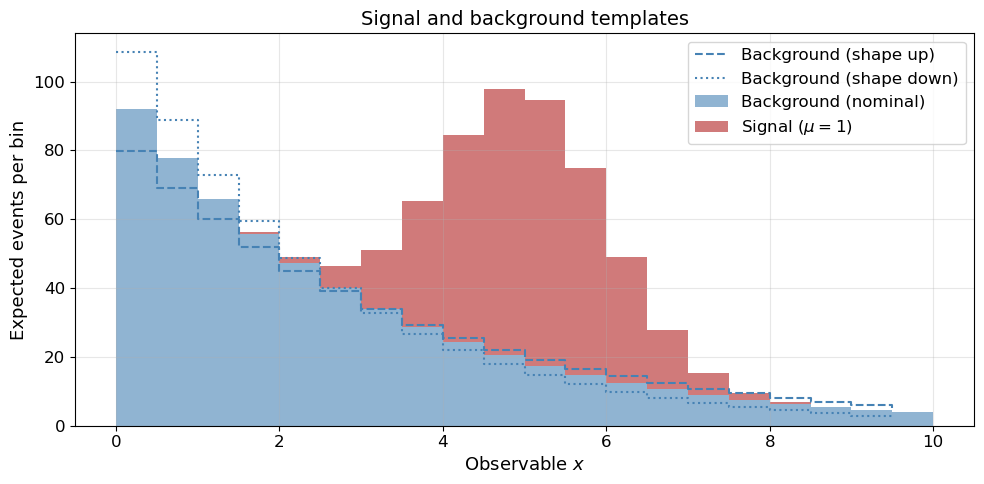

In [12]:
# Build a realistic two-channel model
rng = np.random.default_rng(42)
edges = np.linspace(0, 10, 21)  # 20 bins from 0 to 10
centres = 0.5 * (edges[:-1] + edges[1:])

# Signal: Gaussian peak at x=5
sig_template = 200 * stats.norm.pdf(centres, loc=5, scale=1.0)

# Background: falling exponential
bkg_template = 300 * stats.expon.pdf(centres, scale=3.0)

# Background shape systematic: steeper and shallower slopes
bkg_up   = 300 * stats.expon.pdf(centres, scale=3.5)
bkg_down = 300 * stats.expon.pdf(centres, scale=2.5)

fig, ax = plt.subplots(figsize=(10, 5))
width = np.diff(edges)
ax.bar(centres, bkg_template, width=width, alpha=0.6, color='steelblue',
       edgecolor='none', label='Background (nominal)')
ax.bar(centres, sig_template, width=width, alpha=0.6, color='firebrick',
       edgecolor='none', bottom=bkg_template, label=r'Signal ($\mu=1$)')
ax.step(edges[:-1], bkg_up, where='post', color='steelblue', ls='--',
        label='Background (shape up)')
ax.step(edges[:-1], bkg_down, where='post', color='steelblue', ls=':',
        label='Background (shape down)')
ax.set_xlabel("Observable $x$")
ax.set_ylabel("Expected events per bin")
ax.set_title("Signal and background templates")
ax.legend()
plt.tight_layout()
plt.show()


In [13]:
# Construct the model programmatically
sig_hist = Histogram(sig_template, edges)
bkg_hist = Histogram(bkg_template, edges)
bkg_up_hist = Histogram(bkg_up, edges)
bkg_down_hist = Histogram(bkg_down, edges)

# Signal sample with a free normalisation (the signal strength mu)
signal = Sample("signal", sig_hist)
signal.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))

# Background sample with a shape systematic
background = Sample("background", bkg_hist)
background.add_histosys("bkg_shape", bkg_down_hist, bkg_up_hist,
                        interp_code=InterpolationCode.PIECEWISE_EXPONENTIAL)
background.add_normsys("bkg_norm", lo=0.95, hi=1.05)

print(signal)
print(background)
print(f"Signal parameters:     {[p.name for p in signal.parameters]}")
print(f"Background parameters: {[p.name for p in background.parameters]}")


Sample('signal', nbins=20, modifiers=1)
Sample('background', nbins=20, modifiers=2)
Signal parameters:     ['mu']
Background parameters: ['bkg_shape', 'bkg_norm']


In [14]:
# Generate pseudo-data at mu=1.2 (slightly above SM)
true_mu = 1.2
true_expected = true_mu * sig_template + bkg_template
pseudo_data = rng.poisson(true_expected).astype(float)

# Assemble the signal region channel
sr = Channel("SR")
sr.add_sample(signal)
sr.add_sample(background)
sr.set_data(pseudo_data)

# Build the model
model = Model("tutorial")
model.add_channel(sr)

print(model)
print(f"Total bins:      {model.total_nbins}")
print(f"Parameters:      {model.parameter_names}")
print(f"Nominal values:  {model.nominal_values()}")


Model('tutorial', channels=['SR'], parameters=['mu', 'bkg_shape', 'bkg_norm'])
Total bins:      20
Parameters:      ['mu', 'bkg_shape', 'bkg_norm']
Nominal values:  {'mu': 1.0, 'bkg_shape': 0.0, 'bkg_norm': 0.0}


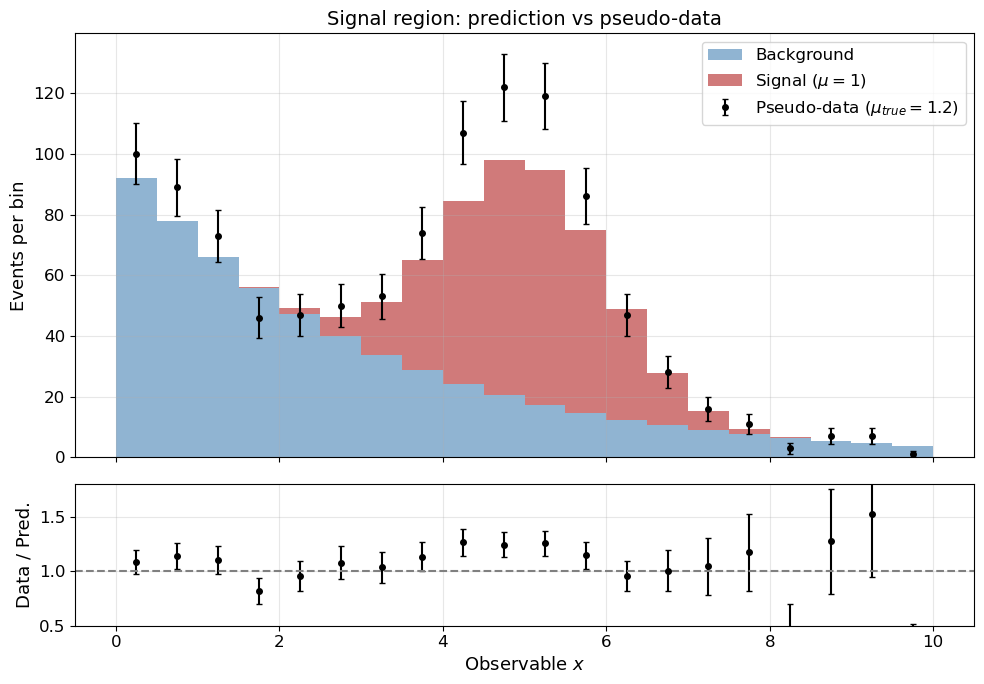

In [15]:
# Visualise: expected vs observed
expected_nom = model.expected({"mu": 1.0, "bkg_shape": 0.0, "bkg_norm": 0.0})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7),
                                gridspec_kw={'height_ratios': [3, 1]},
                                sharex=True)

# Upper panel: stacked prediction vs data
ax1.bar(centres, bkg_template, width=width, alpha=0.6, color='steelblue',
        edgecolor='none', label='Background')
ax1.bar(centres, sig_template, width=width, alpha=0.6, color='firebrick',
        edgecolor='none', bottom=bkg_template, label=r'Signal ($\mu=1$)')
ax1.errorbar(centres, pseudo_data, yerr=np.sqrt(pseudo_data),
             fmt='ko', ms=4, capsize=2, label=r'Pseudo-data ($\mu_{true}=1.2$)')
ax1.set_ylabel("Events per bin")
ax1.legend()
ax1.set_title("Signal region: prediction vs pseudo-data")

# Lower panel: data / prediction ratio
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = np.where(expected_nom > 0, pseudo_data / expected_nom, 1.0)
    ratio_err = np.where(expected_nom > 0, np.sqrt(pseudo_data) / expected_nom, 0.0)

ax2.errorbar(centres, ratio, yerr=ratio_err, fmt='ko', ms=4, capsize=2)
ax2.axhline(1.0, color='gray', ls='--')
ax2.set_ylabel("Data / Pred.")
ax2.set_xlabel("Observable $x$")
ax2.set_ylim(0.5, 1.8)

plt.tight_layout()
plt.show()


## 5. The Likelihood Function

The probability of observing $n_i$ events in bin $i$ when $\nu_i$ are
expected follows a Poisson distribution:

$$P(n_i \mid \nu_i) = \frac{\nu_i^{n_i}\, e^{-\nu_i}}{n_i!}$$

The full binned likelihood for all bins across all channels is

$$\mathcal{L}(\mu, \boldsymbol{\theta}) = \prod_{\text{channels}} \prod_{\text{bins}} P(n_i \mid \nu_i(\mu, \boldsymbol{\theta}))
\;\times\; \prod_j \pi(\theta_j)$$

where $\boldsymbol{\theta}$ are the nuisance parameters and $\pi(\theta_j)$
are Gaussian constraint terms encoding prior knowledge about each systematic:
$\pi(\theta_j) = \mathcal{N}(\theta_j \mid 0, 1)$.

In the **extended** likelihood we additionally include a Poisson term
for the total expected count: $P(N_{\text{total}} \mid \sum \nu_i)$.

We minimise the negative log-likelihood:

$$-\ln \mathcal{L} = -\sum_i \ln P(n_i \mid \nu_i) - \sum_j \ln \pi(\theta_j)$$

The `BinnedNLL` class computes exactly this quantity, and the `fit()`
function wraps iminuit's MIGRAD + HESSE (and optionally MINOS) to find
the minimum.

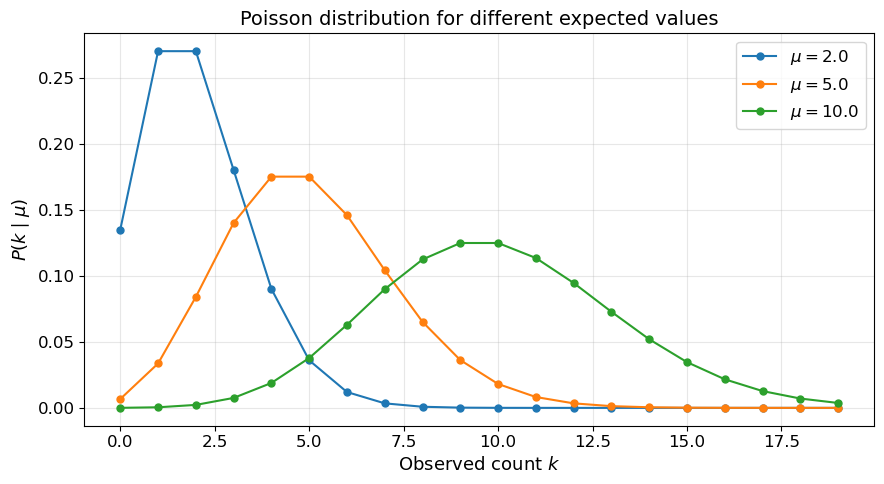

In [16]:
# The Poisson log-pdf (continuous approximation via gammaln)
k_vals = np.arange(0, 20)
mu_vals = [2.0, 5.0, 10.0]

fig, ax = plt.subplots(figsize=(9, 5))
for mu_val in mu_vals:
    logp = _poisson_logpdf(k_vals.astype(float), np.full_like(k_vals, mu_val, dtype=float))
    ax.plot(k_vals, np.exp(logp), 'o-', label=r'$\mu = $'+f'{mu_val}', ms=5)

ax.set_xlabel("Observed count $k$")
ax.set_ylabel(r"$P(k \mid \mu)$")
ax.set_title("Poisson distribution for different expected values")
ax.legend()
plt.tight_layout()
plt.show()


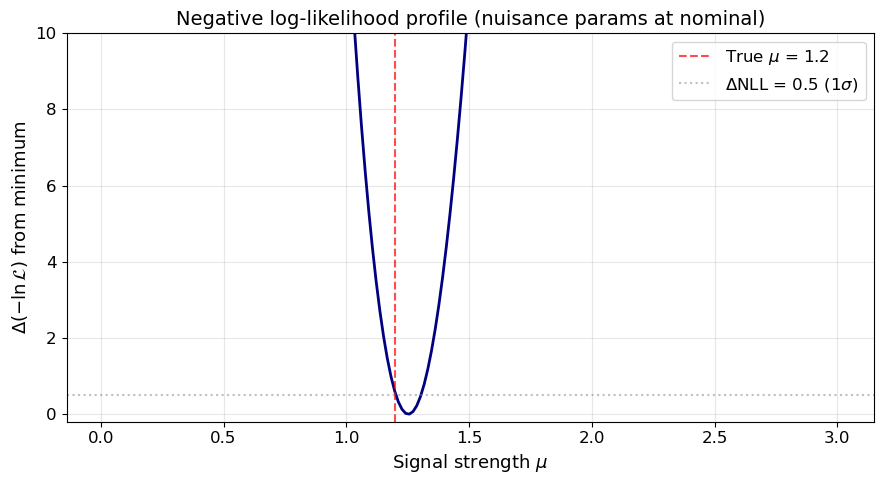

In [17]:
# Scan the NLL as a function of mu
nll = BinnedNLL(model)
mu_scan = np.linspace(0.01, 3.0, 200)
nll_vals = []
for mu_val in mu_scan:
    nll_vals.append(nll(np.array([mu_val, 0.0, 0.0])))  # mu, bkg_shape, bkg_norm
nll_vals = np.array(nll_vals)

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(mu_scan, nll_vals - nll_vals.min(), color='navy', linewidth=2)
ax.axvline(true_mu, color='red', ls='--', alpha=0.7, label=r'True $\mu$ = '+f'{true_mu}')
ax.axhline(0.5, color='gray', ls=':', alpha=0.5, label=r'$\Delta$NLL = 0.5 (1$\sigma$)')
ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"$\Delta(-\ln \mathcal{L})$ from minimum")
ax.set_title("Negative log-likelihood profile (nuisance params at nominal)")
ax.legend()
ax.set_ylim(-0.2, 10)
plt.tight_layout()
plt.show()


The NLL profile above holds nuisance parameters fixed at their nominal
values (0, 0).  In a proper fit, we **profile** them: at each value of
$\mu$, we re-minimise over all $\theta_j$.  This broadens the parabola
(larger uncertainties) and can shift the minimum, correctly accounting
for systematic effects.

## 6. Fitting the Model

The `fit()` function performs the full minimisation.  It runs MIGRAD
(gradient descent) to find the minimum, HESSE to estimate the
covariance matrix (parabolic errors), and optionally MINOS to compute
asymmetric confidence intervals by walking along the likelihood contour.

In [18]:
# Run the fit
result = fit(model, run_minos=True)

print(f"Fit converged: {result.valid}")
print(f"Min NLL:       {result.nll_min:.2f}")
print()
print("Best-fit parameters:")
for name in model.parameter_names:
    val = result.bestfit[name]
    err = result.errors[name]
    minos = result.minos_errors[name] if result.minos_errors else None
    line = f"  {name:12s} = {val:+.4f} +/- {err:.4f}"
    if minos:
        line += f"  (MINOS: {minos[0]:+.4f} / {minos[1]:+.4f})"
    print(line)

print(f"\nTrue mu was {true_mu}, fitted mu = {result.bestfit['mu']:.3f}")
pull = (result.bestfit['mu'] - true_mu) / result.errors['mu']
print(f"Pull: {pull:.2f} sigma")


Fit converged: True
Min NLL:       65.09

Best-fit parameters:
  mu           = +1.2639 +/- 0.0852  (MINOS: -0.0842 / +0.0858)
  bkg_shape    = -0.4113 +/- 0.4725  (MINOS: -0.4819 / +0.4798)
  bkg_norm     = -0.0032 +/- 0.9856  (MINOS: -1.0014 / +1.0082)

True mu was 1.2, fitted mu = 1.264
Pull: 0.75 sigma


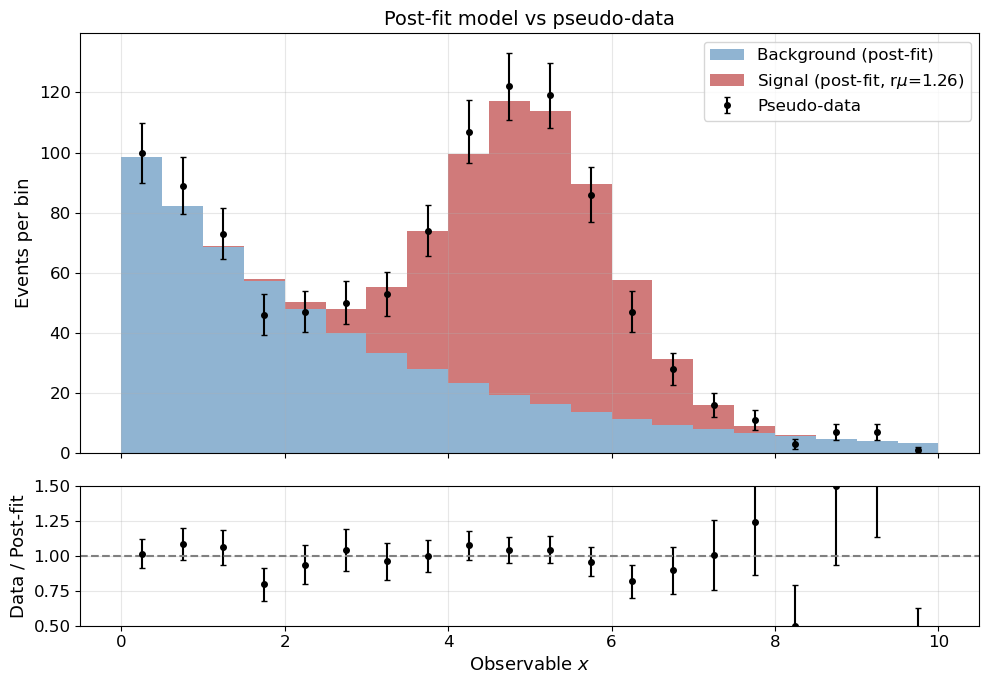

In [19]:
# Visualise the post-fit model vs data
postfit_expected = model.expected(result.bestfit)
postfit_sig = result.bestfit['mu'] * sig_template
postfit_bkg = postfit_expected - postfit_sig

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7),
                                gridspec_kw={'height_ratios': [3, 1]},
                                sharex=True)

ax1.bar(centres, postfit_bkg, width=width, alpha=0.6, color='steelblue',
        edgecolor='none', label='Background (post-fit)')
ax1.bar(centres, postfit_sig, width=width, alpha=0.6, color='firebrick',
        edgecolor='none', bottom=postfit_bkg,
        label=r'Signal (post-fit, r$\mu$'+f'={result.bestfit["mu"]:.2f})')
ax1.errorbar(centres, pseudo_data, yerr=np.sqrt(pseudo_data),
             fmt='ko', ms=4, capsize=2, label='Pseudo-data')
ax1.set_ylabel("Events per bin")
ax1.legend()
ax1.set_title("Post-fit model vs pseudo-data")

with np.errstate(divide='ignore', invalid='ignore'):
    ratio_post = np.where(postfit_expected > 0, pseudo_data / postfit_expected, 1.0)
    ratio_post_err = np.where(postfit_expected > 0, np.sqrt(pseudo_data) / postfit_expected, 0.0)

ax2.errorbar(centres, ratio_post, yerr=ratio_post_err, fmt='ko', ms=4, capsize=2)
ax2.axhline(1.0, color='gray', ls='--')
ax2.set_ylabel("Data / Post-fit")
ax2.set_xlabel("Observable $x$")
ax2.set_ylim(0.5, 1.5)

plt.tight_layout()
plt.show()


## 7. The Profile Likelihood Ratio

The **profile likelihood ratio** is the central test statistic in
HistFactory analyses.  It is defined as

$$t(\mu) = 2 \left[ \ell(\mu, \hat{\hat{\boldsymbol{\theta}}}) - \ell(\hat{\mu}, \hat{\boldsymbol{\theta}}) \right]$$

where $\ell$ is the negative log-likelihood, $\hat{\mu}$ and
$\hat{\boldsymbol{\theta}}$ are the unconditional best-fit values,
and $\hat{\hat{\boldsymbol{\theta}}}$ are the nuisance parameter values
that minimise $\ell$ with $\mu$ fixed (the "conditional" or "profiled"
fit).

By construction $t(\hat{\mu}) = 0$ and $t(\mu) \geq 0$ everywhere.
According to Wilks' theorem, for large samples $t(\mu)$ follows a
$\chi^2$ distribution with 1 degree of freedom when $\mu$ is the true
value.  This means $t(\mu) = 1$ corresponds to a $1\sigma$ interval and
$t(\mu) = 3.84$ to a 95% CL exclusion.

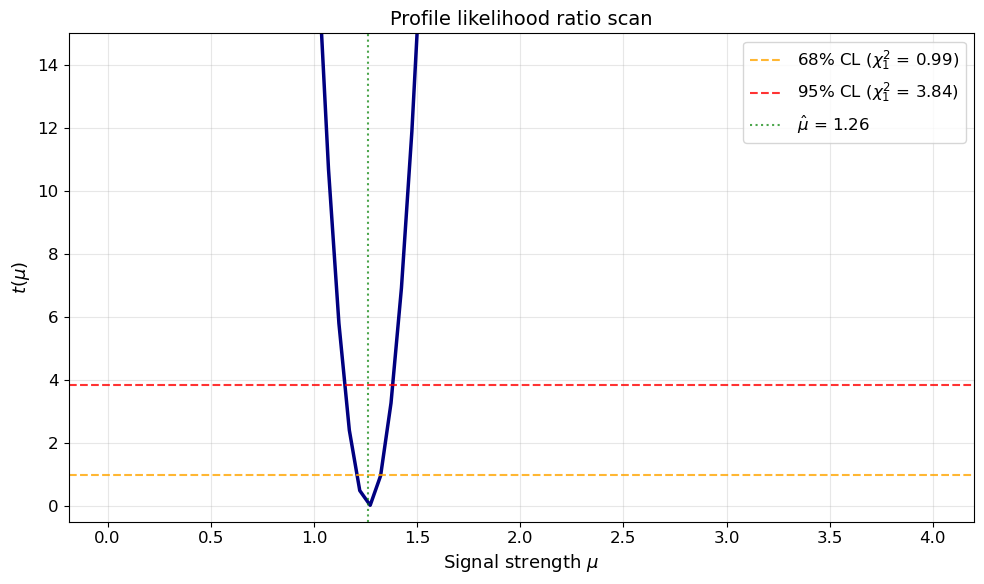

In [20]:
# Profile likelihood ratio scan
mu_scan_plr = np.linspace(0.01, 4.0, 80)
plr_values = []
for mu_val in mu_scan_plr:
    t = profile_likelihood_ratio(model, "mu", mu_val,
                                 unconditional_nll=result.nll_min)
    plr_values.append(t)
plr_values = np.array(plr_values)

# chi2 thresholds
chi2_68 = stats.chi2.ppf(0.68, df=1)  # ~1.0
chi2_95 = stats.chi2.ppf(0.95, df=1)  # ~3.84

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mu_scan_plr, plr_values, color='navy', linewidth=2.5)
ax.axhline(chi2_68, color='orange', ls='--', alpha=0.8, label=r'68% CL ($\chi^2_1$ = '+f'{chi2_68:.2f})')
ax.axhline(chi2_95, color='red', ls='--', alpha=0.8, label=r'95% CL ($\chi^2_1$ = '+f'{chi2_95:.2f})')
ax.axvline(result.bestfit['mu'], color='green', ls=':', alpha=0.7,
           label=r'$\hat{{\mu}}$ = '+f'{result.bestfit["mu"]:.2f}')

ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"$t(\mu)$")
ax.set_title("Profile likelihood ratio scan")
ax.set_ylim(-0.5, 15)
ax.legend()
plt.tight_layout()
plt.show()


## 8. Upper Limits

An **upper limit** at confidence level $1 - \alpha$ (typically 95%) is
the value $\mu_{\text{up}}$ where the profile likelihood ratio crosses
the critical threshold:

$$t(\mu_{\text{up}}) = F^{-1}_{\chi^2(1)}(1 - \alpha)$$

For 95% CL, the threshold is $\chi^2_1(0.95) \approx 3.84$.  Any value
of $\mu > \mu_{\text{up}}$ is excluded at the 95% confidence level.

The `upper_limit()` function performs this inversion numerically using
Brent's root-finding method.

95% CL upper limit on mu: 1.383
Best-fit mu:              1.264 +/- 0.085
True mu:                  1.2


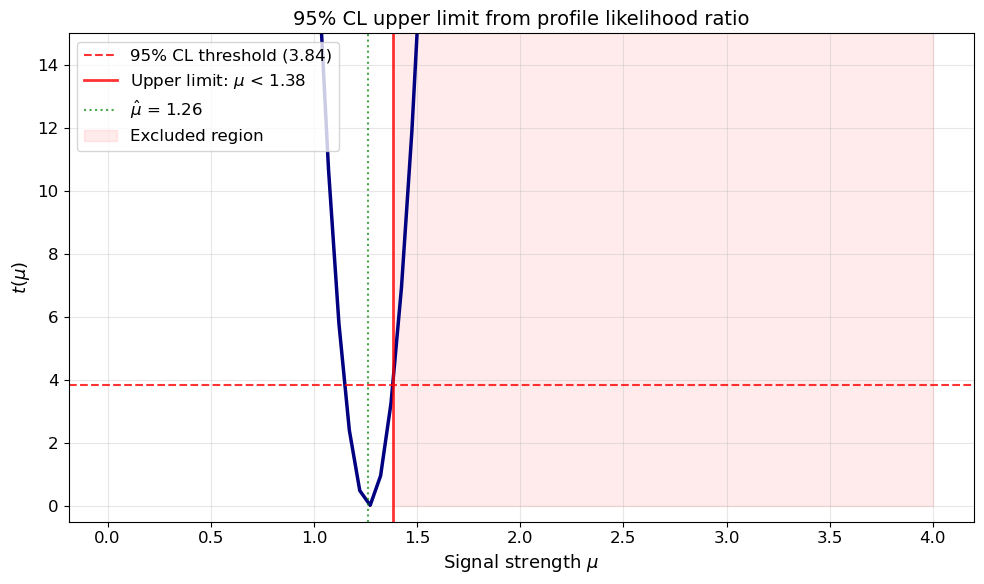

In [21]:
# Compute the 95% CL upper limit
ul = upper_limit(model, "mu", cl=0.95)
print(f"95% CL upper limit on mu: {ul:.3f}")
print(f"Best-fit mu:              {result.bestfit['mu']:.3f} +/- {result.errors['mu']:.3f}")
print(f"True mu:                  {true_mu}")

# Show on the PLR scan
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mu_scan_plr, plr_values, color='navy', linewidth=2.5)
ax.axhline(chi2_95, color='red', ls='--', alpha=0.8, label=f'95% CL threshold ({chi2_95:.2f})')
ax.axvline(ul, color='red', linewidth=2, alpha=0.8, label=r'Upper limit: $\mu$ < '+f'{ul:.2f}')
ax.axvline(result.bestfit['mu'], color='green', ls=':', alpha=0.7,
           label=r'$\hat{{\mu}}$ = '+f'{result.bestfit["mu"]:.2f}')
ax.fill_betweenx([0, 20], ul, 4.0, color='red', alpha=0.08, label='Excluded region')
ax.set_xlabel(r"Signal strength $\mu$")
ax.set_ylabel(r"$t(\mu)$")
ax.set_title("95% CL upper limit from profile likelihood ratio")
ax.set_ylim(-0.5, 15)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


## 9. Discovery Significance

The **discovery test** asks: is the data consistent with the
background-only hypothesis ($\mu = 0$)?  The test statistic is

$$q_0 = \begin{cases} t(\mu=0) & \text{if } \hat{\mu} \geq 0 \\ 0 & \text{if } \hat{\mu} < 0 \end{cases}$$

Under the background-only hypothesis and for large samples,
$q_0 \sim \frac{1}{2}\chi^2_0 + \frac{1}{2}\chi^2_1$.  The
significance in Gaussian standard deviations is $Z = \sqrt{q_0}$,
and the one-sided p-value is $p = \Phi(-Z)$, where $\Phi$ is the
standard normal CDF.

Particle physics uses $Z \geq 5$ as the conventional threshold for a
"discovery" ($p \approx 2.87 \times 10^{-7}$) and $Z \geq 3$ for
"evidence".

In [22]:
# Discovery significance for our model (has signal injected at mu=1.2)
z_val, p_val = discovery_significance(model, "mu")

print(f"Discovery significance: Z = {z_val:.2f} sigma")
print(f"p-value:                p = {p_val:.4e}")
print(f"Consistent: p = Phi(-Z) = {stats.norm.sf(z_val):.4e}")

if z_val >= 5:
    verdict = "Discovery (>5 sigma)!"
elif z_val >= 3:
    verdict = "Evidence (>3 sigma)"
else:
    verdict = "Not significant"
print(f"Verdict: {verdict}")


Discovery significance: Z = 27.16 sigma
p-value:                p = 9.3392e-163
Consistent: p = Phi(-Z) = 9.3392e-163
Verdict: Discovery (>5 sigma)!


In [23]:
# Compare: build a background-only dataset and check significance
bkg_only_data = rng.poisson(bkg_template).astype(float)

sr_bkg = Channel("SR_bkg")
sig_bkg = Sample("signal", sig_hist)
sig_bkg.add_normfactor("mu", nominal=1.0, bounds=(0.0, 10.0))
bkg_bkg = Sample("background", bkg_hist)
sr_bkg.add_sample(sig_bkg)
sr_bkg.add_sample(bkg_bkg)
sr_bkg.set_data(bkg_only_data)

model_bkg = Model("bkg_only_test")
model_bkg.add_channel(sr_bkg)

z_bkg, p_bkg = discovery_significance(model_bkg, "mu")
ul_bkg = upper_limit(model_bkg, "mu")

print(f"Background-only pseudo-experiment:")
print(f"  Z = {z_bkg:.2f}, p = {p_bkg:.4f}")
print(f"  95% CL upper limit on mu: {ul_bkg:.3f}")


Background-only pseudo-experiment:
  Z = 0.00, p = 0.5000
  95% CL upper limit on mu: 0.026


## 10. Putting It All Together

The workflow of a template-fit analysis follows a clear sequence.

You start by constructing histogram templates from simulation: one for
each process, in each analysis region.  Systematic uncertainties are
encoded as variations of these templates (shape) or their normalisations
(rate).

These templates are assembled into Samples with their modifiers,
grouped into Channels with observed data, and collected into a Model.
The Model defines the full likelihood function.

Fitting the model to data yields the best-fit parameter values and
their uncertainties. The profile likelihood ratio then provides the
test statistic for hypothesis testing: upper limits quantify how much
signal is consistent with the data, and discovery significance
quantifies how incompatible the data is with the background-only
hypothesis.

This is the statistical foundation on which the Higgs boson discovery
was built, and it remains the standard methodology for essentially all
measurements and searches at the LHC.